<a href="https://colab.research.google.com/github/liorhirsch/Kaggle-Landmark-ML-Challange/blob/master/our_custom_NN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Upload data from google drive

In [1]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


# Build training data


In [0]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
from joblib import Parallel, delayed
import multiprocessing


**Upload to memory all the photos.**

The data will be array of arrays. Each sub-array represents one landmark and will contain tuples of landmark photo and landmark id.

In [0]:
DATADIR = "drive/My Drive/photos/"
CATEGORIES =  os.listdir(DATADIR);
print('Found %d categories in : %s' % (len(CATEGORIES), DATADIR))
training_data = []
IMG_SIZE = 100
   
def create_training_data(category):
    data = []
    print("Building training data for landmark id %s" %category);
    path = os.path.join(DATADIR, category)  # path tolandmark photos
    landmark_id = category
    for img in os.listdir(path):
        try:
            img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
            new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
            data.append([new_array, landmark_id])
        except Exception as e:
            pass   # do nothing
    return data;
          
num_cores = multiprocessing.cpu_count();
print('building the training data on %d cores' % num_cores)
training_data_nested=Parallel(n_jobs=num_cores)(delayed(create_training_data)(category) for category in CATEGORIES)

**Augmentated Data Generation**

Creates images generators both for the test and the training data, to create additional data

In [0]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [0]:
train_datagen=ImageDataGenerator(
                              rotation_range=0,
                              width_shift_range=0,
                               height_shift_range=0,
                               shear_range=0,
                               zoom_range=[0.8, 1.25],
                               horizontal_flip=True,
                               vertical_flip=False,
                               fill_mode='reflect',
                               data_format='channels_last',
                               brightness_range=[0.5, 1.5]) #included in our dependencies

test_datagen = ImageDataGenerator(
                               rotation_range=30,
                               width_shift_range=0.1,
                               height_shift_range=0.1,
                               shear_range=0.01,
                               zoom_range=[0.8, 1.25],
                               horizontal_flip=True,
                               vertical_flip=False,
                               fill_mode='reflect',
                               data_format='channels_last',
                               brightness_range=[0.5, 1.5]) #included in our dependencies


 Uses the data as a stream object to enable batching on it instead of loading them all together to the ram using the ImageDataGenerator

In [61]:
image_size = (100,100)
batch_size = 10

training_data_dir = 'drive/My Drive/photos'
validation_data_dir = 'drive/My Drive/test'

train_generator=train_datagen.flow_from_directory(training_data_dir,
                                                 target_size=image_size,
                                                 color_mode='rgb',
                                                 batch_size=batch_size,
                                                 class_mode='categorical',
                                                 shuffle=True)

# validation_generator = test_datagen.flow_from_directory(
#                                         validation_data_dir,
#                                          target_size=image_size,
#                                          color_mode='rgb',
#                                         class_mode = "categorical")

Found 75315 images belonging to 100 classes.


In [62]:
x_batch, y_batch = next(train_generator)
print(x_batch) # RGB 2d array
print(y_batch) # The label (class)

[[[[181. 181. 181.]
   [172. 171. 174.]
   [ 75.  75.  99.]
   ...
   [181. 181. 181.]
   [181. 181. 181.]
   [181. 181. 181.]]

  [[181. 181. 181.]
   [180. 180. 180.]
   [178. 180. 178.]
   ...
   [181. 181. 181.]
   [181. 181. 181.]
   [181. 181. 181.]]

  [[181. 181. 181.]
   [181. 181. 181.]
   [181. 181. 181.]
   ...
   [181. 181. 181.]
   [181. 181. 181.]
   [181. 181. 181.]]

  ...

  [[ 94.  48.  42.]
   [ 21.  15.  19.]
   [ 64.   9.  26.]
   ...
   [ 64.  71.  81.]
   [ 67.  52.  49.]
   [ 67.  72.  67.]]

  [[ 75.  36.  26.]
   [ 56.  18.  15.]
   [ 39.  22.  27.]
   ...
   [ 39.  47.  44.]
   [ 34.  32.  36.]
   [ 23.  27.  29.]]

  [[ 54.  40.  39.]
   [103.  37.  32.]
   [ 43.  18.  15.]
   ...
   [ 29.  29.  17.]
   [ 26.  29.  32.]
   [ 19.  22.  26.]]]


 [[[ 65.  61.  74.]
   [ 92.  67.  80.]
   [ 80.  63.  76.]
   ...
   [ 59.  49.  59.]
   [ 45.  33.  47.]
   [ 40.  36.  40.]]

  [[ 59.  53.  67.]
   [ 78.  57.  74.]
   [ 51.  49.  70.]
   ...
   [ 57.  52.  55.]
 

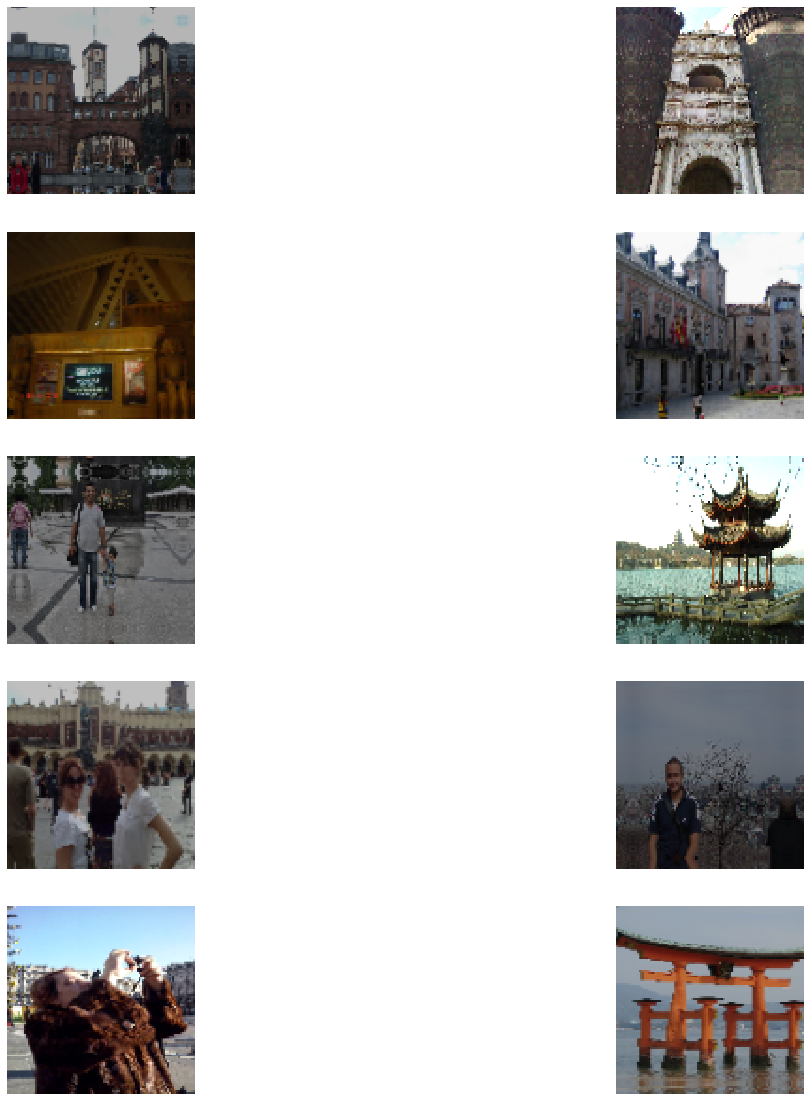

In [63]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(20, 20))
for i in range(10):
    plt.subplot(5,2,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    image = x_batch[i]
    image= image.astype(np.uint8)
    plt.imshow(image)

# Train

In [0]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, Conv3D
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping

**Normalize the images.**

In [0]:
x_batch = x_batch/255.0
print(x_batch)

In [0]:
model = Sequential()
model.add(Conv2D(64, (3,3), input_shape = x_batch.shape[1:]))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(64, (3,3)))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2,2)))

#Flatening the data
model.add(Flatten())
model.add(Dense(150))
model.add(Activation("relu"))

#output layer
model.add(Dense(100))
model.add(Activation('softmax'))

In [0]:
model.summary()


In [0]:
adamOptimizer = tf.keras.optimizers.Adam(lr=0.001)

model.compile(loss = 'sparse_categorical_crossentropy', 
             optimizer='adam',
             metrics=['accuracy'])

# model.compile(loss='categorical_crossentropy', optimizer='adam',\
#  metrics=['accuracy'])

In [0]:
y=[a.tolist().index(1) for a in y_batch];
print(y)

In [57]:

model.fit(x_batch, y, batch_size=32, epochs = 30, validation_split=0.1)

# model.fit(X, y, batch_size=64, epochs=1, verbose=1, \
# validation_split=0.2, shuffle=True)

Train on 9 samples, validate on 1 samples
Epoch 1/30
9/9 [==============================] - 0s 3ms/step - loss: 2.0537 - acc: 0.2222 - val_loss: 12.8021 - val_acc: 0.0000e+00
Epoch 2/30
9/9 [==============================] - 0s 3ms/step - loss: 2.0583 - acc: 0.2222 - val_loss: 12.6525 - val_acc: 0.0000e+00
Epoch 3/30
9/9 [==============================] - 0s 3ms/step - loss: 2.0598 - acc: 0.2222 - val_loss: 12.5180 - val_acc: 0.0000e+00
Epoch 4/30
9/9 [==============================] - 0s 3ms/step - loss: 2.0584 - acc: 0.2222 - val_loss: 12.4025 - val_acc: 0.0000e+00
Epoch 5/30
9/9 [==============================] - 0s 4ms/step - loss: 2.0548 - acc: 0.2222 - val_loss: 12.3123 - val_acc: 0.0000e+00
Epoch 6/30
9/9 [==============================] - 0s 3ms/step - loss: 2.0500 - acc: 0.2222 - val_loss: 12.2537 - val_acc: 0.0000e+00
Epoch 7/30
9/9 [==============================] - 0s 3ms/step - loss: 2.0446 - acc: 0.2222 - val_loss: 12.2324 - val_acc: 0.0000e+00
Epoch 8/30
9/9 [===========

In [0]:
train_loss, train_acc = model.evaluate(X,y)


In [0]:
print(train_loss)
print(train_acc)